# Balanced Tree Clothing Company Analysis
 
In this Notebook, we will analyze the Balanced Tree Clothing Company dataset. The dataset contains the sales data of the company using SQL. 

we will utilize the following SQL skills 
- Compounded Self Joins 
- Multiple Join types 
- Aggregating data
- cleaning and formatting data 
- Common Table Expressions (CTEs)
- Creating Views
- Nested Queries 
- Creating Value Combinations
- Data Visualization 

In [1]:
!sqlite3 clothing_company.sqlite < clothing_company.sql

## Relevant Imports

In [96]:
import sqlite3 as sql3
import pandas as pd
import matplotlib.pyplot as plt

## Creating a database connection

In [3]:
database = 'clothing_company.sqlite'
connection = sql3.connect(database)
cursor = connection.cursor()

In [4]:
# list all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ").fetchall()

[('product_hierarchy',), ('product_prices',), ('sales',)]

## Tables in the database

### Product hierarchy

In [5]:
# see the first few rows of the table and return the result as a pandas dataframe
product_hierarchy = pd.read_sql_query("SELECT * FROM product_hierarchy", connection, index_col='id')
product_hierarchy

,parent_id,level_text,level_name
id,,,
1,NaN,Womens,Category
2,NaN,Mens,Category
3,1.0,Jeans,Segment
4,1.0,Jacket,Segment
5,2.0,Shirt,Segment
6,2.0,Socks,Segment
7,3.0,Navy Oversized,Style
8,3.0,Black Straight,Style
9,3.0,Cream Relaxed,Style


### Product Prices

In [6]:
product_prices = pd.read_sql_query("SELECT * FROM product_prices", connection, index_col='id')

product_prices

,product_id,price
id,,
7,c4a632,13
8,e83aa3,32
9,e31d39,10
10,d5e9a6,23
11,72f5d4,19
12,9ec847,54
13,5d267b,40
14,c8d436,10
15,2a2353,57


### sales

In [7]:
sales = pd.read_sql_query("SELECT * FROM sales", connection, index_col='prod_id')
sales.head()

,qty,price,discount,member,txn_id,start_txn_time
prod_id,,,,,,
c4a632,4,13,17,t,54f307,2021-02-13 01:59:43.296
5d267b,4,40,17,t,54f307,2021-02-13 01:59:43.296
b9a74d,4,17,17,t,54f307,2021-02-13 01:59:43.296
2feb6b,2,29,17,t,54f307,2021-02-13 01:59:43.296
c4a632,5,13,21,t,26cc98,2021-01-19 01:39:00.3456


In [8]:
sales.shape

(15095, 6)

## Creating Product details
- the above table `product_hierarchy`, The information in a hierarchical format
1. Top of the hierarchy is the **Category**: whther the product is for men or women
2. Next level in the hierarchy is the **Segment**, which lists the different types of clothing for each **Category**
3. The next level is the **Style**, which lists the products themselves in different styles under each **Segment**

- In the table `product_prices`, we have the prices of each product on the **Style** level in `product_hierarchy` table

 
We want to make this information in a format that is much easier to work with. We will create a table `product_details` as follows:
| product_id | price | product_name | category_id | segment_id | style_id | category_name | segment_name | style_name |
|------------|-------|--------------|-------------|------------|----------|---------------|--------------|------------|
| c4a632     | 13    | Navy Oversized Jeans - Womens | 1 | 3 | 7 | Womens | Jeans | Navy Oversized |
| e83aa3     | 32    | Black Straight Jeans - Womens | 1 | 3 | 8 | Womens | Jeans | Black Straight |

We will assign each product to its corresponding category and segment. As well as associating each product with its corresponding price.

In [9]:
product_details_sql = """
SELECT h.id, h.parent_id, p.product_id, p.price, h.level_text AS style_name, h.id AS style_id
FROM product_prices AS p
LEFT JOIN product_hierarchy AS h
ON p.id = h.id
"""
product_details = pd.read_sql_query(product_details_sql, connection)
product_details

,id,parent_id,product_id,price,style_name,style_id
0,7,3,c4a632,13,Navy Oversized,7
1,8,3,e83aa3,32,Black Straight,8
2,9,3,e31d39,10,Cream Relaxed,9
3,10,4,d5e9a6,23,Khaki Suit,10
4,11,4,72f5d4,19,Indigo Rain,11
5,12,4,9ec847,54,Grey Fashion,12
6,13,5,5d267b,40,White Tee,13
7,14,5,c8d436,10,Teal Button Up,14
8,15,5,2a2353,57,Blue Polo,15
9,16,6,f084eb,36,Navy Solid,16


The above table contains each product and its corresponding price, we will join it on the `product_hierarchy` again to get the segment 

In [10]:
product_details_sql = """
WITH product_price_style AS (
SELECT h.id, h.parent_id, p.product_id, p.price, h.level_text AS style_name, h.id AS style_id
FROM product_prices AS p
LEFT JOIN product_hierarchy AS h
ON p.id = h.id
)

SELECT ps.parent_id AS id, h.parent_id, ps.product_id, ps.price, ps.style_name, ps.style_id, h.level_text AS segment_name, ps.parent_id AS segment_id
FROM product_price_style AS ps
LEFT JOIN product_hierarchy AS h
ON ps.parent_id = h.id
"""
product_details = pd.read_sql_query(product_details_sql, connection)
product_details

,id,parent_id,product_id,price,style_name,style_id,segment_name,segment_id
0,3,1,c4a632,13,Navy Oversized,7,Jeans,3
1,3,1,e83aa3,32,Black Straight,8,Jeans,3
2,3,1,e31d39,10,Cream Relaxed,9,Jeans,3
3,4,1,d5e9a6,23,Khaki Suit,10,Jacket,4
4,4,1,72f5d4,19,Indigo Rain,11,Jacket,4
5,4,1,9ec847,54,Grey Fashion,12,Jacket,4
6,5,2,5d267b,40,White Tee,13,Shirt,5
7,5,2,c8d436,10,Teal Button Up,14,Shirt,5
8,5,2,2a2353,57,Blue Polo,15,Shirt,5
9,6,2,f084eb,36,Navy Solid,16,Socks,6


- Now the above product contains each product, its price and its segment, we will join it again a final time on itself to get the category

In [11]:
product_details_sql = """
WITH product_price_style AS (
SELECT h.id, h.parent_id, p.product_id, p.price, h.level_text AS style_name, h.id AS style_id
FROM product_prices AS p
LEFT JOIN product_hierarchy AS h
ON p.id = h.id
),

product_price_style_segment AS (
SELECT ps.parent_id AS id, h.parent_id, ps.product_id, ps.price, ps.style_name, ps.style_id, h.level_text AS segment_name, ps.parent_id AS segment_id
FROM product_price_style AS ps
LEFT JOIN product_hierarchy AS h
ON ps.parent_id = h.id
)

SELECT psg.product_id, psg.price, psg.style_name || ' ' || psg.segment_name || ' - ' || h.level_text AS product_name, h.id AS category_id, psg.segment_id, psg.style_id, h.level_text AS category_name, psg.segment_name ,psg.style_name
FROM product_price_style_segment AS psg
LEFT JOIN product_hierarchy AS h
ON psg.parent_id = h.id
"""
product_details = pd.read_sql_query(product_details_sql, connection, index_col='product_id')
product_details

,price,product_name,category_id,segment_id,style_id,category_name,segment_name,style_name
product_id,,,,,,,,
c4a632,13,Navy Oversized Jeans - Womens,1,3,7,Womens,Jeans,Navy Oversized
e83aa3,32,Black Straight Jeans - Womens,1,3,8,Womens,Jeans,Black Straight
e31d39,10,Cream Relaxed Jeans - Womens,1,3,9,Womens,Jeans,Cream Relaxed
d5e9a6,23,Khaki Suit Jacket - Womens,1,4,10,Womens,Jacket,Khaki Suit
72f5d4,19,Indigo Rain Jacket - Womens,1,4,11,Womens,Jacket,Indigo Rain
9ec847,54,Grey Fashion Jacket - Womens,1,4,12,Womens,Jacket,Grey Fashion
5d267b,40,White Tee Shirt - Mens,2,5,13,Mens,Shirt,White Tee
c8d436,10,Teal Button Up Shirt - Mens,2,5,14,Mens,Shirt,Teal Button Up
2a2353,57,Blue Polo Shirt - Mens,2,5,15,Mens,Shirt,Blue Polo


In [12]:
product_details.to_sql('product_details', connection, if_exists='replace')

12

In [13]:
# query the database to get the tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ").fetchall()

[('product_hierarchy',), ('product_prices',), ('sales',), ('product_details',)]

## Analysis
- We will divide our analysis into 3 parts:
1. **High-level sales analysis**: we will address some high-level questions about the sales data
    - What was the total quantity sold for all products?
    - What is the total generated revenue for all products before discounts?
    - What was the total discount amount for all products?
2. **Transaction analysis**: we will address some questions about the transactions
    - How many unique transactions are there?
    - What is the average unique products purchased in each transaction?
    - What are the 25th, 50th and 75th percentile values for the revenue per transaction?
    - What is the average discount value per transaction?
    - What is the percentage split of all transactions for members vs non-members?
    - What is the average revenue for member transactions and non-member transactions?
3. **Product analysis**: we will address some questions about the products
    - What are the top 3 products by total revenue before discount?
    - What is the total quantity, revenue and discount for each segment?
    - What is the top selling product for each segment?
    - What is the total quantity, revenue and discount for each category?
    - What is the top selling product for each category?
    - What is the percentage split of revenue by product for each segment?
    - What is the percentage split of revenue by segment for each category?
    - What is the percentage split of total revenue by category?
    - What is the total transaction “penetration” for each product? (hint: penetration = number of transactions where at least 1 quantity of a product was purchased divided by total number of transactions)
    - What is the most common combination of at least 1 quantity of any 3 products in a 1 single transaction?

## Create a main table view that addresses all the above questions

In [21]:
drop_view = "DROP VIEW IF EXISTS main_table"
cursor.execute(drop_view)

main_table_view = """
CREATE VIEW main_table AS
SELECT
    s.prod_id AS product_id,
    p.product_name,
    s.qty,
    s.price,
    s.qty * s.price AS total_price,
    CAST(discount AS FLOAT) / 100 AS discount_per,
    s.qty * s.price * CAST(discount AS FLOAT) / 100 AS discount_amount,
    s.qty * s.price * (1 - CAST(discount AS FLOAT) / 100) AS revenue,
    s.member,
    s.txn_id,
    s.start_txn_time,
    p.category_id,
    p.segment_id,
    p.style_id,
    p.category_name,
    p.segment_name,
    p.style_name
FROM sales AS s
LEFT JOIN product_details AS p
ON s.prod_id = p.product_id
"""
cursor.execute(main_table_view)
connection.commit()

In [22]:
pd.read_sql_query("SELECT * FROM main_table", connection).head(3)

,product_id,product_name,qty,price,total_price,discount_per,discount_amount,revenue,member,txn_id,start_txn_time,category_id,segment_id,style_id,category_name,segment_name,style_name
0,c4a632,Navy Oversized Jeans - Womens,4,13,52,0.17,8.84,43.16,t,54f307,2021-02-13 01:59:43.296,1,3,7,Womens,Jeans,Navy Oversized
1,5d267b,White Tee Shirt - Mens,4,40,160,0.17,27.20,132.80,t,54f307,2021-02-13 01:59:43.296,2,5,13,Mens,Shirt,White Tee
2,b9a74d,White Striped Socks - Mens,4,17,68,0.17,11.56,56.44,t,54f307,2021-02-13 01:59:43.296,2,6,17,Mens,Socks,White Striped


## high-level sales analysis

### what is the total quantity sold for all products?

In [23]:
total_quantity_sold = """
SELECT SUM(qty) AS total_quantity_sold
FROM main_table
"""
total_quantity_sold = pd.read_sql_query(total_quantity_sold, connection, index_col='total_quantity_sold')
total_quantity_sold

""
total_quantity_sold
45216


### What is the total generated revenue for all products before discounts?

In [24]:
total_revenue_sql = """
SELECT SUM(total_price) AS total_revenues_before
FROM main_table
"""
total_revenue = pd.read_sql_query(total_revenue_sql,connection, index_col='total_revenues_before')
total_revenue

""
total_revenues_before
1289453


the total revenue generated is $1,289,453

### What was the total discount amount for all products?
- discounts are made for each transaction, and they are in percentages, so to get the total discount, we need to get the total price for each transaction and subtract the discount percentage from it

In [30]:
total_discount_sql = """
SELECT SUM(discount_amount) AS total_discount 
FROM main_table
"""
pd.read_sql_query(total_discount_sql,connection,index_col='total_discount')

""
total_discount
156229.14


- the total discount is $156,229.14

- Therefore, the total revenue after discount is 1,289,453 - 156,229.14 = $1,133,223.86 , to Prove this, we will calculate the total revenue after discount

In [31]:
total_revenue_after_discount_sql = """
SELECT SUM(revenue) AS total_revenue_after_discount
FROM main_table
"""
total_revenue_after_discount = pd.read_sql_query(total_revenue_after_discount_sql, connection, index_col='total_revenue_after_discount')
total_revenue_after_discount

""
total_revenue_after_discount
1133223.86


## Transaction analysis

### How many unique transactions are there?

In [33]:
unique_transactions = """
SELECT COUNT(DISTINCT txn_id) AS num_transactions
FROM main_table
"""
unique_transactions = pd.read_sql_query(unique_transactions, connection, index_col='num_transactions')
unique_transactions

""
num_transactions
2500


### what is the average unique products purchased in each transaction?

In [38]:
avg_uniqe_products = """
SELECT ROUND(AVG(num_unique_products)) AS avg_num_products
FROM (SELECT 
    txn_id,
    COUNT(DISTINCT product_id) AS num_unique_products
FROM main_table
GROUP BY txn_id) AS num_products
"""
avg_uniqe_products = pd.read_sql_query(avg_uniqe_products, connection, index_col='avg_num_products')
avg_uniqe_products

""
avg_num_products
6.0


- there is average of 6 unique products purchased in each transaction

### What are the 25th, 50th and 75th percentile values for the revenue per transaction?

In [42]:
revenue_per_txn_sql = """
SELECT SUM(revenue) AS revenue
FROM main_table
GROUP BY txn_id
"""
revenue_per_txn_df = pd.read_sql_query(revenue_per_txn_sql, connection)

# Calculate percentiles
percentiles = revenue_per_txn_df['revenue'].quantile([0.25, 0.5, 0.75])

percentiles

0.25    326.4050
0.50    441.2250
0.75    572.7625
Name: revenue, dtype: float64

### what is the average discount value per transaction?

In [45]:
discount_per_txn = """
SELECT ROUND(AVG(discount),2) AS avg_discount
from (SELECT SUM(discount_amount) AS discount
      FROM main_table
      GROUP BY txn_id) AS discount_per_txn
"""
discount_per_txn = pd.read_sql_query(discount_per_txn, connection, index_col='avg_discount')
discount_per_txn

""
avg_discount
62.49


### what is the Percentage split of all transactions for members vs non-members?

In [46]:
# get datatypes of sales columns
pd.read_sql_query("PRAGMA table_info(sales)", connection)

,cid,name,type,notnull,dflt_value,pk
0,0,prod_id,VARCHAR(6),0,None,0
1,1,qty,INTEGER,0,None,0
2,2,price,INTEGER,0,None,0
3,3,discount,INTEGER,0,None,0
4,4,member,BOOLEAN,0,None,0
5,5,txn_id,VARCHAR(6),0,None,0
6,6,start_txn_time,TIMESTAMP,0,None,0


- member is a boolean value, so we can get the percentage split by counting the number of transactions for each member type and dividing by the total number of transactions

In [47]:
members_percentages = """
WITH member_info AS(
SELECT
    txn_id,
    CASE  WHEN Min(member) = 't'
            THEN 1
          ELSE 0 END AS is_member 
FROM main_table
GROUP BY txn_id)

SELECT (CAST(SUM(is_member) AS REAL) / COUNT(*)) * 100 AS members_percentage,
        100 - ((CAST(SUM(is_member) AS REAL) / COUNT(*)) * 100) AS guests_percentage
FROM member_info
"""
members_percentages = pd.read_sql_query(members_percentages,connection)
members_percentages

,members_percentage,guests_percentage
0,60.2,39.8


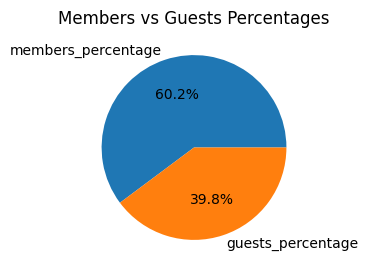

In [113]:
data = members_percentages.iloc[0]

# Create a pie chart
plt.figure(figsize=(5, 3))
plt.pie(data, labels=data.index, autopct='%1.1f%%')
plt.title('Members vs Guests Percentages')
plt.show()

- 60.2% of the transactions are made by members, while 39.8% are made by non-members

### what is the average revenue for member transactions and non-member transactions?

In [53]:
revenue_per_member = """
WITH txn_info AS (
SELECT 
    SUM(revenue) AS revenue,
    MIN(member) AS member
FROM main_table
GROUP BY txn_id)

SELECT 
    member,
    AVG(revenue) AS avg_revenue
FROM txn_info
GROUP BY member
"""

revenue_per_member = pd.read_sql_query(revenue_per_member,connection)
revenue_per_member

,member,avg_revenue
0,f,452.007769
1,t,454.136963


- the average revenue from members is 454.13 and for non-members is 452

## Product analysis

### What are the top 3 products by total revenue before discount?

In [54]:
top_3 = """
SELECT 
    product_name,
    SUM(total_price) AS revenue_before_discounts
FROM main_table
GROUP BY product_name
ORDER BY revenue_before_discounts DESC
LIMIT 3 
"""
top_3 = pd.read_sql_query(top_3,connection)
top_3

,product_name,revenue_before_discounts
0,Blue Polo Shirt - Mens,217683
1,Grey Fashion Jacket - Womens,209304
2,White Tee Shirt - Mens,152000


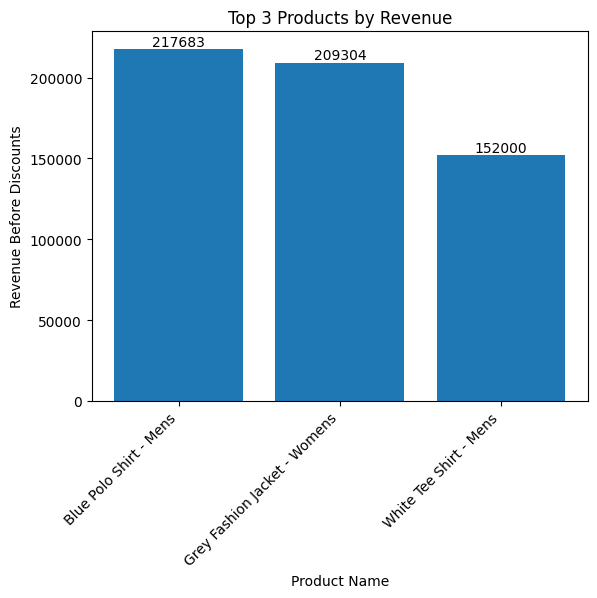

In [119]:
bars = plt.bar(top_3['product_name'], top_3['revenue_before_discounts'], align='center')
plt.xlabel('Product Name')
plt.ylabel('Revenue Before Discounts')
plt.title('Top 3 Products by Revenue')
plt.xticks(rotation=45, ha='right')  # Adjust horizontal alignment to 'right'

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.show()

### What is the total quantity, revenue and discount for each segment?

In [202]:
segment = """
WITH sales_and_products AS (
SELECT *
FROM sales
LEFT JOIN product_details
ON sales.prod_id = product_details.product_id)

SELECT 
    segment_name,
    SUM(qty) AS total_quantity,
    SUM(qty * price * (CAST(discount AS REAL)/100))  AS total_discount,
    SUM(qty * price) * (1 - CAST(MIN(discount) AS REAL)/100) AS total_revenue
FROM sales_and_products
GROUP BY segment_name
"""

segment = pd.read_sql_query(segment,connection)
segment

,segment_name,total_quantity,total_discount,total_revenue
0,Jacket,11385,44277.46,366983.0
1,Jeans,11349,25343.97,208350.0
2,Shirt,11265,49594.27,406143.0
3,Socks,11217,37013.44,307977.0


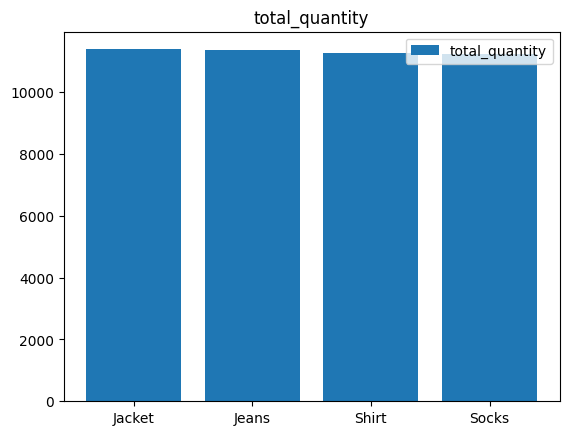

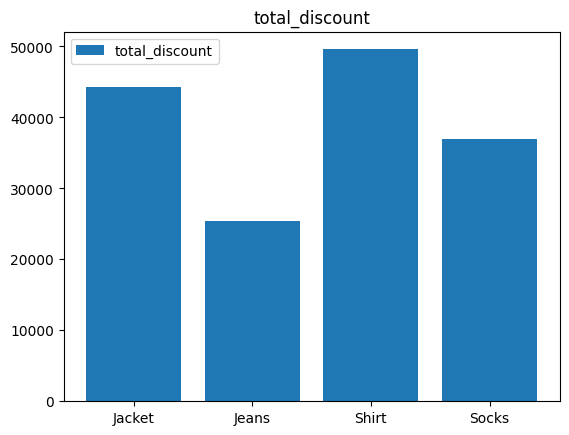

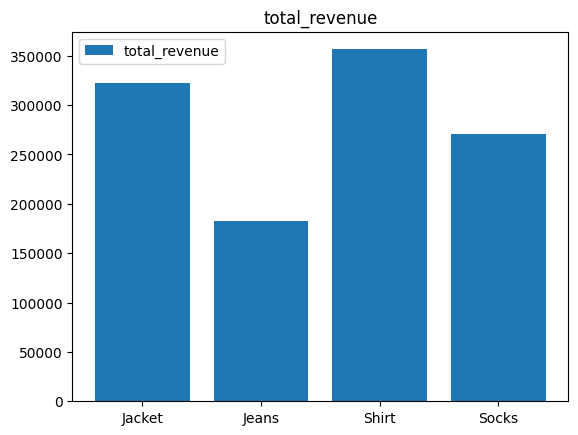

In [124]:
for col in segment.columns[1:]:
    plt.figure()  # This creates a new figure for each plot
    plt.bar(segment['segment_name'], segment[col], label=col)
    plt.title(col)
    plt.legend()
    plt.show()

### What is the top selling product for each segment?

In [125]:
top_product_per_segment = """
SELECT segment_name, product_name, total_revenue
FROM(
SELECT
    segment_name,
    product_name,
    style_name,
    SUM(revenue) AS total_revenue,
    RANK() OVER(PARTITION BY segment_name ORDER BY SUM(revenue) DESC) AS rank
FROM main_table
GROUP BY segment_id,style_id 
ORDER BY segment_name, style_name, rank 
) AS top_segments
WHERE rank = 1
"""
top_product_per_segment = pd.read_sql_query(top_product_per_segment,connection)
top_product_per_segment

,segment_name,product_name,total_revenue
0,Jacket,Grey Fashion Jacket - Womens,183912.12
1,Jeans,Black Straight Jeans - Womens,106407.04
2,Shirt,Blue Polo Shirt - Mens,190863.93
3,Socks,Navy Solid Socks - Mens,119861.64


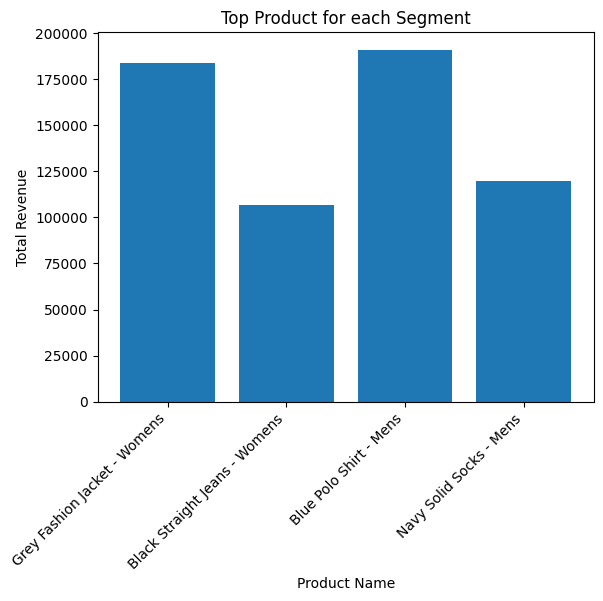

In [128]:
plt.bar(top_product_per_segment['product_name'], top_product_per_segment['total_revenue'])
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.title('Top Product for each Segment')
plt.xticks(rotation=45, ha='right')
plt.show()

### what is the total quantity, revenue and discount for each category?

In [69]:
category = """
SELECT 
    category_name,
    SUM(qty) AS total_quantity,
    SUM(discount_amount)  AS total_discount,
    SUM(revenue) AS total_revenue
FROM main_table
GROUP BY category_name
"""
category = pd.read_sql_query(category,connection)
category

,category_name,total_quantity,total_discount,total_revenue
0,Mens,22482,86607.71,627512.29
1,Womens,22734,69621.43,505711.57


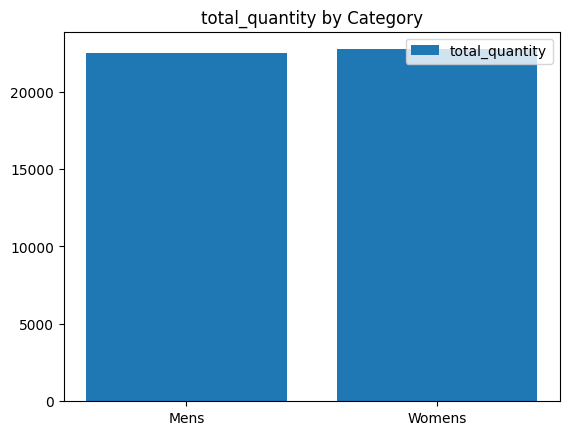

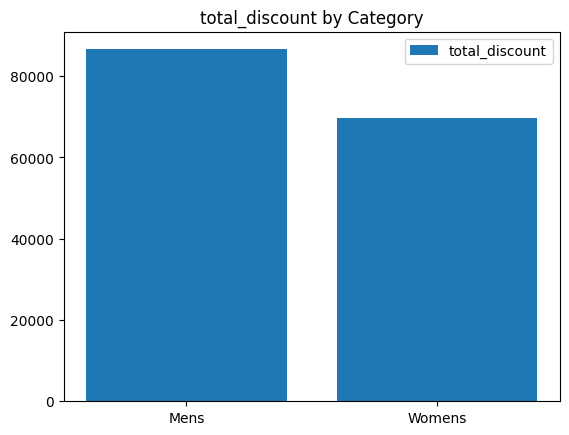

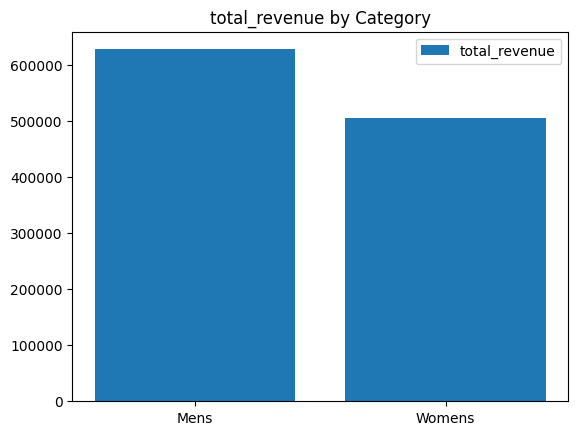

In [130]:
for col in category.columns[1:]:
    plt.figure()  # This creates a new figure for each plot
    plt.bar(category['category_name'], category[col], label=col)
    plt.title(col + ' by Category')
    plt.legend()
    plt.show()

### what is the top selling product for each category?

In [131]:
top_product_per_category = """
SELECT category_name, product_name, total_revenue
FROM(
SELECT
    category_name,
    product_name,
    style_name,
    SUM(revenue) AS total_revenue,
    RANK() OVER(PARTITION BY category_name ORDER BY SUM(revenue) DESC) AS rank
FROM main_table
GROUP BY category_id,style_id 
ORDER BY category_name, style_name, rank 
) AS top_categories
WHERE rank = 1
"""
top_product_per_category = pd.read_sql_query(top_product_per_category,connection)
top_product_per_category

,category_name,product_name,total_revenue
0,Mens,Blue Polo Shirt - Mens,190863.93
1,Womens,Grey Fashion Jacket - Womens,183912.12


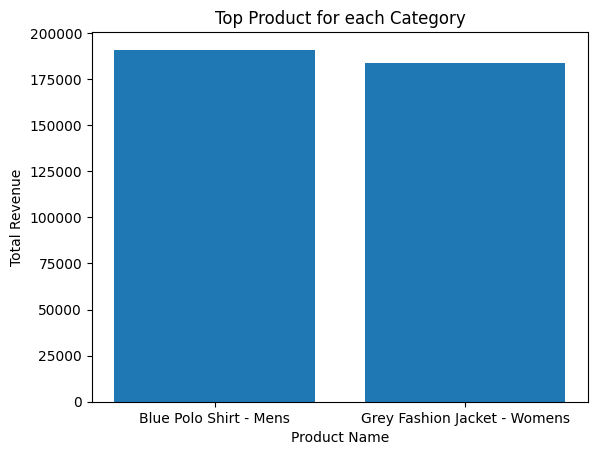

In [134]:
plt.figure()
plt.bar(top_product_per_category['product_name'], top_product_per_category['total_revenue'])
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.title('Top Product for each Category');

### What is the percentage split revenue by product for each segment?

In [80]:
revenues_percentages_segment = """
WITH segment_style_revenue AS (
SELECT
    segment_name,
    style_name,
    SUM(revenue) AS revenue
FROM main_table
GROUP BY segment_id, style_id)

SELECt 
    s.*,
    ROUND(revenue / SUM(revenue) OVER(PARTITION BY segment_name) * 100,1) AS percentage_per_segment
FROM segment_style_revenue AS s
ORDER BY segment_name, percentage_per_segment DESC
"""
revenues_percentages_segment = pd.read_sql_query(revenues_percentages_segment,connection)
revenues_percentages_segment

,segment_name,style_name,revenue,percentage_per_segment
0,Jacket,Grey Fashion,183912.12,57.0
1,Jacket,Khaki Suit,76052.95,23.6
2,Jacket,Indigo Rain,62740.47,19.4
3,Jeans,Black Straight,106407.04,58.1
4,Jeans,Navy Oversized,43992.39,24.0
5,Jeans,Cream Relaxed,32606.60,17.8
6,Shirt,Blue Polo,190863.93,53.5
7,Shirt,White Tee,133622.40,37.5
8,Shirt,Teal Button Up,32062.40,9.0
9,Socks,Navy Solid,119861.64,44.2


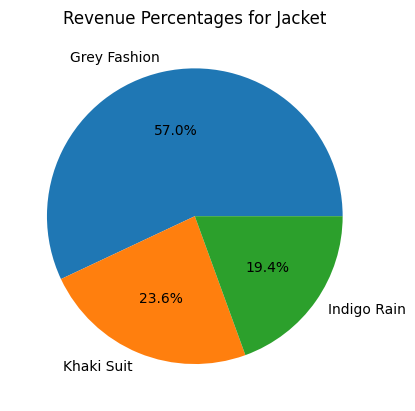

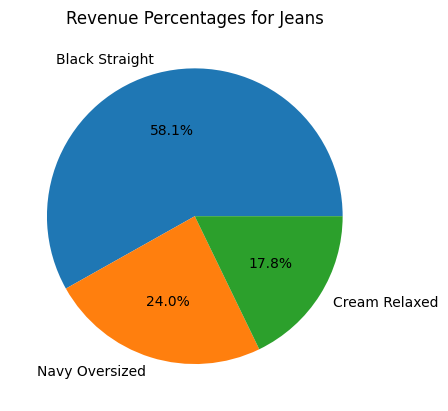

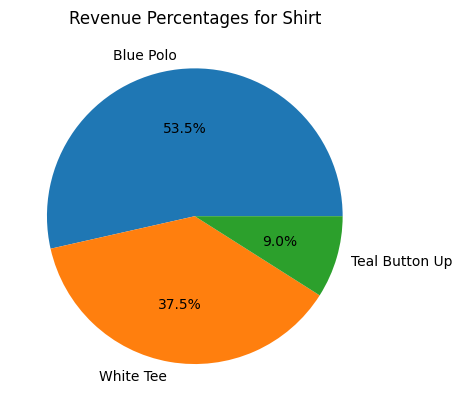

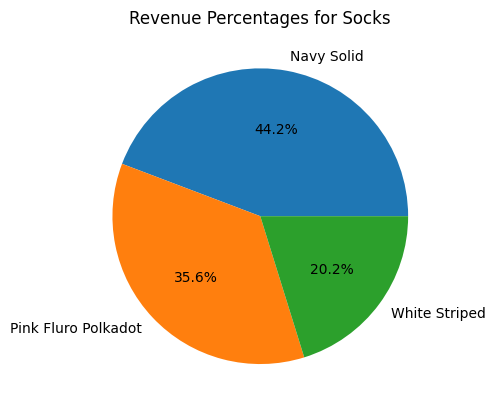

In [138]:
segments = revenues_percentages_segment['segment_name'].unique()
for segment in segments:
    plt.figure()
    plt.pie(revenues_percentages_segment[revenues_percentages_segment['segment_name'] == segment]['revenue'], labels=revenues_percentages_segment[revenues_percentages_segment['segment_name'] == segment]['style_name'], autopct='%1.1f%%')
    plt.title('Revenue Percentages for ' + segment)
    plt.show()

### what is the percentage split revenue by segment for each category?

In [86]:
revenues_percentages_category = """
WITH category_style_revenue AS (
SELECT
    category_name,
    segment_name,
    SUM(revenue) AS revenue
FROM main_table
GROUP BY category_id, segment_id)

SELECt 
    s.*,
    ROUND(revenue / SUM(revenue) OVER(PARTITION BY category_name) * 100,1) AS percentage_per_category
FROM category_style_revenue AS s
ORDER BY category_name, percentage_per_category DESC
"""
revenues_percentages_category = pd.read_sql_query(revenues_percentages_category,connection)
revenues_percentages_category

,category_name,segment_name,revenue,percentage_per_category
0,Mens,Shirt,356548.73,56.8
1,Mens,Socks,270963.56,43.2
2,Womens,Jacket,322705.54,63.8
3,Womens,Jeans,183006.03,36.2


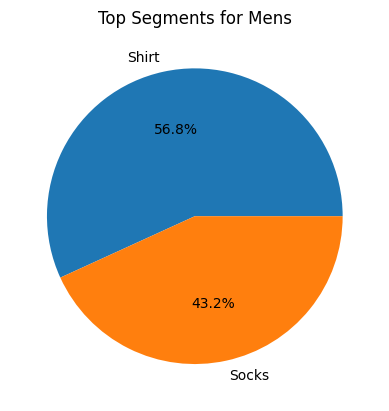

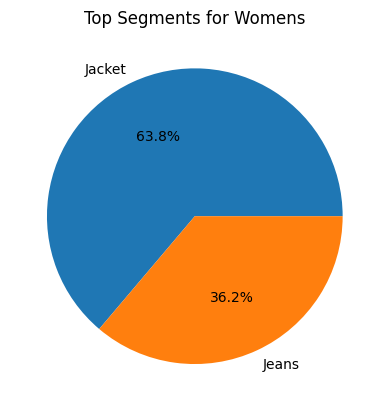

In [140]:
category = revenues_percentages_category['category_name'].unique()
for cat in category:
    plt.figure()
    plt.pie(revenues_percentages_category[revenues_percentages_category['category_name'] == cat]['revenue'], labels=revenues_percentages_category[revenues_percentages_category['category_name'] == cat]['segment_name'], autopct='%1.1f%%')
    plt.title('Top Segments for ' + cat)
    plt.show()

### What is the percentage split of total revenue by category

In [90]:
revenues_per_category = """
WITH category_style_revenue AS (
SELECT
    category_name,
    SUM(revenue) AS revenue
FROM main_table
GROUP BY category_id)

SELECt 
    s.*,
    ROUND(revenue / SUM(revenue) OVER() * 100,1) AS percentage_per_category
FROM category_style_revenue AS s
ORDER BY category_name, percentage_per_category DESC
"""
revenues_per_category = pd.read_sql_query(revenues_per_category,connection)
revenues_per_category

,category_name,revenue,percentage_per_category
0,Mens,627512.29,55.4
1,Womens,505711.57,44.6


Text(0.5, 1.0, 'Total Revenue by Category')

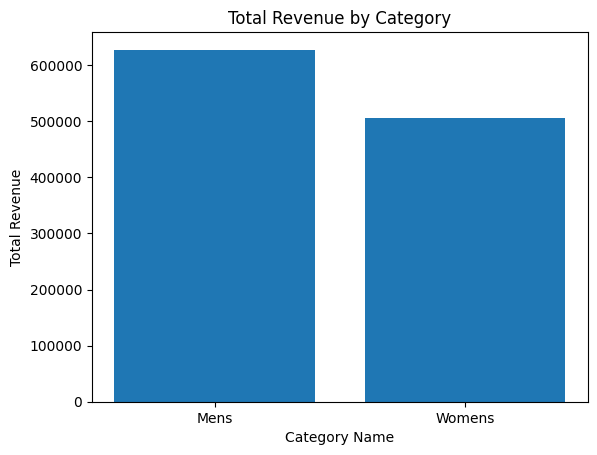

In [142]:
plt.bar(revenues_per_category['category_name'], revenues_per_category['revenue'])
plt.xlabel('Category Name')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Category');

### What is the total transaction “penetration” for each product?
- penetration = number of transactions where at least 1 quantity of a product was purchased divided by total number of transactions

It simply means what is the percetage of transactions each product appeared in

In [91]:
penetration_per_product = """

SELECT product_name,
       CAST(COUNT(txn_id) AS REAL) / (SELECT COUNT(DISTINCT txn_id) FROM sales) * 100 AS penetration_percentage
FROM main_table
GROUP BY product_id
ORDER BY penetration_percentage DESC
"""
penetration_per_product = pd.read_sql_query(penetration_per_product,connection)
penetration_per_product

,product_name,penetration_percentage
0,Navy Solid Socks - Mens,51.24
1,Grey Fashion Jacket - Womens,51.00
2,Navy Oversized Jeans - Womens,50.96
3,White Tee Shirt - Mens,50.72
4,Blue Polo Shirt - Mens,50.72
5,Pink Fluro Polkadot Socks - Mens,50.32
6,Indigo Rain Jacket - Womens,50.00
7,Khaki Suit Jacket - Womens,49.88
8,Black Straight Jeans - Womens,49.84
9,Cream Relaxed Jeans - Womens,49.72


### What is the most common combination of at least 1 quantity of any 3 products in a 1 single transaction?

- To make combinations of 3 in SQl, we will join the table on itself additional 2 times (to result in 3 tables)
    - the join is of type INNER
    - the names shouldn't match (we don't match a value with itself in the combination)
    - if we match row A with row B, don't match row b with row A (we do that by row A < row b, so only 1 of them will match -the largest will be added to the smallest)
- additional rule is that these combinations should be in the same transaction (we create unique combinations of 3 within the transaction, so we will add that condition as well during the join)

- Visual example on the combination process

**Initial Tables:**
### product_details

| product_id | product_name |
| --- | --- |
| 1        | A          |
| 2        | B          |
| 3        | C          |
| 4        | D          |

**CTE: products**
### products

| txn_id | product_name |
| --- | --- |
| 1    | A          |
| 1    | B          |
| 1    | C          |
| 1    | D          |

**First Join: p and p1**
### p and p1

| p.product_name | p1.product_name |
| --- | --- |
| A          | B          |
| A          | C          |
| A          | D          |
| B          | C          |
| B          | D          |
| C          | D          |

**Second Join: p, p1, and p2**
### p, p1, and p2

| p.product_name | p1.product_name | p2.product_name |
| --- | --- | --- |
| A          | B          | C          |
| A          | B          | D          |
| A          | C          | D          |
| B          | C          | D          |

**Final Result**
### Final Result

| product_1 | product_2 | product_3 | times_bought_together | rank |
| --- | --- | --- | --- | --- |
| A        | B        | C        | 1                    | 1   |
| A        | B        | D        | 1                    | 1   |
| A        | C        | D        | 1                    | 1   |
| B        | C        | D        | 1                    | 1   |

In [92]:
group_sql = """
with products AS(
      SELECT
        txn_id,
        product_name
      FROM
        main_table
    )
    
    SELECT
      p.product_name AS product_1,
      p1.product_name AS product_2,
      p2.product_name AS product_3,
      COUNT(*) AS times_bought_together,
      ROW_NUMBER() OVER(
        ORDER BY
          COUNT(*) DESC
      ) AS rank
    FROM
      products AS p
      INNER JOIN products AS p1 ON p.txn_id = p1.txn_id
      AND p.product_name != p1.product_name
      AND p.product_name < p1.product_name
      INNER JOIN products AS p2 ON p.txn_id = p2.txn_id
      AND p.product_name != p2.product_name
      AND p1.product_name != p2.product_name
      AND p.product_name < p2.product_name
      AND p1.product_name < p2.product_name
    GROUP BY
      p.product_name,
      p1.product_name,
      p2.product_name
"""
pd.read_sql_query(group_sql, connection)

,product_1,product_2,product_3,times_bought_together,rank
0,Grey Fashion Jacket - Womens,Teal Button Up Shirt - Mens,White Tee Shirt - Mens,352,1
1,Black Straight Jeans - Womens,Indigo Rain Jacket - Womens,Navy Solid Socks - Mens,349,2
2,Black Straight Jeans - Womens,Grey Fashion Jacket - Womens,Pink Fluro Polkadot Socks - Mens,347,3
3,Blue Polo Shirt - Mens,Grey Fashion Jacket - Womens,Teal Button Up Shirt - Mens,347,4
4,Blue Polo Shirt - Mens,Grey Fashion Jacket - Womens,White Striped Socks - Mens,347,5
...,...,...,...,...,...
215,Cream Relaxed Jeans - Womens,Pink Fluro Polkadot Socks - Mens,White Tee Shirt - Mens,290,216
216,Indigo Rain Jacket - Womens,Khaki Suit Jacket - Womens,Pink Fluro Polkadot Socks - Mens,289,217
217,Cream Relaxed Jeans - Womens,White Striped Socks - Mens,White Tee Shirt - Mens,288,218
218,Indigo Rain Jacket - Womens,Khaki Suit Jacket - Womens,Navy Oversized Jeans - Womens,287,219


we got 220 rows because we have 12 products, and the number of unique 3-combinations are 12C3 = 220 combination